# Change Detection with DEMs

## Introduction

Add prose

- Insperation for study area
- Link to fridge

In [1]:
from pathlib import Path

# Define some path constants for use later in the exercise
NOTEBOOK_DIR = Path(__name__).resolve().parent
DATA_DIR = NOTEBOOK_DIR / "data"

## Study Area

This exercise will look at the change to Columbia Glacier, AK, USA using ArcticDEM strips. 

Columbia Glacier is "one of the most rapidly changing glaciers in the world." [[NASA Earth Observatory](https://earthobservatory.nasa.gov/world-of-change/ColumbiaGlacier)]. The rapid retreat of the glacier's terminus will allow us to demonstrate an obvious change within our strip DEM archive spanning a little more than a decade.

A GeoJson file (`aoi.geojson`) delineating the Area of interest has been provided alongside this notebook. In this section, we will load this in an interactive map and familiarize ourselves with the area.

In [2]:
import geopandas as gpd

AOI_GEOJSON = NOTEBOOK_DIR / "aoi.geojson"

# Load the AOI as a GeoDataFrame
aoi: gpd.GeoDataFrame = gpd.read_file(AOI_GEOJSON)

In [8]:
# Check out the content of the aoi
print(f"CRS: {aoi.crs}")
print("Content:")
print(aoi.head())

CRS: EPSG:4326
Content:
               name                                           geometry
0  Area of Interest  POLYGON ((-147.07638 61.11004, -147.27669 61.0...


In [11]:
import leafmap


def initialize_default_interactive_map() -> leafmap.Map:
    """Returns a leafmap.Map object with common UI elements preconfigured. Use within
    the body of specific interactive map functions to initialize the Map object."""

    # Initialize a default Map
    m = leafmap.Map()

    # Add helpful GUI elements to the map interface
    m.add_gui(name="layer_manager", position="topright", opened=False)

    return m

In [12]:
from pathlib import Path
import leafmap


def create_interactive_aoi_map(aoi_geojson: Path) -> leafmap.Map:
    """Returns an interactive map loaded with basemaps and the provided AOI loaded from a geojson file."""

    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # No raster data yet

    # Add vector data
    m.add_geojson(str(aoi_geojson), layer_name="Area of Interest", zoom_to_layer=True)

    return m

The next cell uses the map functions defined above to create an interactive map of our study area. 

The basemap that is initially visible is `ESRI WorldImagery`. Zoom in and out around the AOI. Newer images are used at the closer zoom levels, which allows us to see a significant change in the location of the glacier terminus.

A second basemap, `USGS.USImagery`, is attached as well. Use the **Layer Manager** in the top right of the map to toggle its visibility. This basemap uses even older imagery, which shows an even larger change of the glacier terminus.

In [13]:
interactive_map = create_interactive_aoi_map(AOI_GEOJSON)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Finding Strip DEMs

In this section, we will search the ArcticDEM strip DEM archive for DEMs we can use to show and quantify the change to this glacier.

The heavy-lifting is accomplished using Thomas Chudley's `pDEMtools` library. [[Repo](https://github.com/trchudley/pdemtools)] [[Docs](https://pdemtools.readthedocs.io/)] This library provides STAC-like search and loading functionality for PGC DEM products.

The following 3 cells define and execute functions to download a parquet of the ArcticDEM strip index. 

The strip index is also available as a Shapefile, FileGeoDatabase, or GeoPackage. Links for each can be found on the [PGC ArcticDEM Webpage](https://www.pgc.umn.edu/data/arcticdem/).

In [14]:
from pathlib import Path
import requests


def download_strip_index_archive(url: str, output_dir: Path) -> Path:
    """Downloads the zipped strip index to the provided output directory and returns a
    path to the downloaded file."""

    # Make sure the output directory exists
    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    # Download the zip archive to the output directory
    r = requests.get(url, stream=True)

    # Throw an Exception if the request returned an error status
    r.raise_for_status()

    # Write the archive to the filesystem
    archive = output_dir / "strip_index_archive.zip"
    with open(archive, "wb") as f:
        for chunk in r.iter_content(chunk_size=128):
            f.write(chunk)

    return archive

In [17]:
import shutil


def unzip_strip_index_archive(archive: Path) -> Path:
    """Unzips the content of an archive into the same directory as the archive."""

    shutil.unpack_archive(filename=archive, extract_dir=archive.parent)

In [18]:
STRIP_INDEX_ARCHIVE_URL = "https://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Strip_Index_latest_gpqt.zip"
STRIP_DIR = DATA_DIR / "strips"

# Download the strip index archive to a subfolder in the data directory
strip_index_archive = download_strip_index_archive(
    url=STRIP_INDEX_ARCHIVE_URL, output_dir=STRIP_DIR
)

# Unzip the archive
unzip_strip_index_archive(archive=strip_index_archive)

The next few cells search the strip index for any strip that overlaps at least 90% of our AOI. 

In [19]:
from pathlib import Path

import pdemtools as pdt
from shapely import Polygon


def get_intersecting_strips(
    strip_index: Path, bounds: Polygon, min_aoi_frac: float
) -> gpd.GeoDataFrame:
    """Wrapper around the search functionality in pdemtools. Returns a GeoDataFrame of matching
    strips sorted by acquisition date."""

    strips: gpd.GeoDataFrame = pdt.search(
        index_fpath=str(strip_index),
        bounds=bounds,
        min_aoi_frac=min_aoi_frac,
    )

    return strips.sort_values("acqdate1")

In [20]:
# The name of the unzipped strip index will change with new versions of ArcticDEM
# Rather than hardcoding the name here, we will search for the parquet file that
# was unzipped.
STRIP_INDEX = list(STRIP_DIR.glob("*/*.parquet"))[0]

# The geometries in the ArcticDEM strip index are in EPSG:3413, but our aoi is in
# EPSG:4326. We need to reproject the geometry before using it as our search bounds.
bounds: Polygon = aoi.to_crs("EPSG:3413").iloc[0].geometry

# Define the minimum overlap percentage between our AOI and any strip DEM.
# Higher percentages will (usually) result in fewer matches.
min_aoi_frac = 0.90

strips = get_intersecting_strips(
    strip_index=STRIP_INDEX, bounds=bounds, min_aoi_frac=min_aoi_frac
)
print(f"Found {strips.shape[0]} strips matching the search criteria")

Found 28 strips matching the search criteria


In [22]:
# Look at the first 5 rows of the matching strips
strips.head()

fid                                             dem_id  \
375797  375798  SETSM_s2s041_GE01_20120616_1050410000CCCE00_10...   
375815  375816  SETSM_s2s041_GE01_20120813_1050410000829A00_10...   
375788  375789  SETSM_s2s041_GE01_20121012_1050410000283800_10...   
375722  375723  SETSM_s2s041_WV01_20130610_1020010020861300_10...   
375799  375800  SETSM_s2s041_WV02_20130712_103001002578FB00_10...   

                                               pairname  \
375797  GE01_20120616_1050410000CCCE00_1050410000CAD600   
375815  GE01_20120813_1050410000829A00_1050410000759100   
375788  GE01_20121012_1050410000283800_105041000027B200   
375722  WV01_20130610_1020010020861300_1020010024444C00   
375799  WV02_20130712_103001002578FB00_1030010024C0FD00   

                                               stripdemid sensor1 sensor2  \
375797  GE01_20120616_1050410000CCCE00_1050410000CAD60...    GE01    GE01   
375815  GE01_20120813_1050410000829A00_105041000075910...    GE01    GE01   
375788  GE01_20121012_1050410000283800_105041000027B20...    GE01    GE01   
375722  WV01_20130610_1020010020861300_1020010024444C0...    WV01    WV01   
375799  WV02_20130712_103001002578FB00_1030010024C0FD0...    WV02    WV02   

              catalogid1        catalogid2            acqdate1  \
375797  1050410000CCCE00  1050410000CAD600 2012-06-16 20:51:00   
375815  1050410000829A00  1050410000759100 2012-08-13 21:03:40   
375788  1050410000283800  105041000027B200 2012-10-12 20:49:32   
375722  1020010020861300  1020010024444C00 2013-06-10 21:20:08   
375799  103001002578FB00  1030010024C0FD00 2013-07-12 22:04:24   

                  acqdate2  ...  cloud_area_sqkm  cloud_area_percent  \
375797 2012-06-16 20:50:05  ...       190.363244            0.422274   
375815 2012-08-13 21:02:51  ...        48.151820            0.127937   
375788 2012-10-12 20:48:38  ...        77.422264            0.168067   
375722 2013-06-10 21:20:53  ...       107.061772            0.172530   
375799 2013-07-12 22:03:24  ...        84.499264            0.136048   

       avg_convergence_angle avg_expected_height_accuracy avg_sun_elev1  \
375797          -9999.000000                 -9999.000000     51.066667   
375815          -9999.000000                 -9999.000000     42.466667   
375788          -9999.000000                 -9999.000000     20.666667   
375722             36.385234                     1.075711     51.800000   
375799             30.387618                     1.301678     50.830001   

       avg_sun_elev2      rmse  \
375797     51.000000  1.890100   
375815     42.433333  1.099500   
375788     20.633333  1.282000   
375722     51.830001  0.628011   
375799     50.870000  0.791388   

                                                  fileurl  \
375797  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375815  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375788  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375722  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   
375799  https://data.pgc.umn.edu/elev/dem/setsm/Arctic...   

                                                    s3url  \
375797  https://polargeospatialcenter.github.io/stac-b...   
375815  https://polargeospatialcenter.github.io/stac-b...   
375788  https://polargeospatialcenter.github.io/stac-b...   
375722  https://polargeospatialcenter.github.io/stac-b...   
375799  https://polargeospatialcenter.github.io/stac-b...   

                                                     geom  
375797  POLYGON ((-3112793.238 679439.148, -3112793.23...  
375815  POLYGON ((-3114586.000 679052.000, -3112793.23...  
375788  POLYGON ((-3124224.238 679859.654, -3112793.23...  
375722  POLYGON ((-3112793.238 678400.589, -3112793.23...  
375799  POLYGON ((-3114324.000 679188.000, -3112793.23...  

[5 rows x 33 columns]

Next, we will look at previews of the DEMs to select two to carry forward in our analysis. 

The background of the figures is set to a light purple to make it easy to identify areas of NoData/Bad pixels. Some of the previews will also show read outlines. These are the edge of the strip DEM.

In [23]:
import matplotlib.pyplot as plt


def preview_strip(strips: gpd.GeoDataFrame, bounds: Polygon, index: int) -> plt.figure:
    """Construct a figure for the row matching the provided index."""

    # Extract the row of interest as a one-row GeoDataFrame
    row = strips.iloc[[index]]

    # Load the remote preview image, limited to the provided bounds
    preview = pdt.load.preview(row, bounds)

    # Close any pervious plt objects hanging around in memory
    plt.close("all")

    # Build the figure
    fig, ax = plt.subplots(layout="constrained")
    ax.set_facecolor("plum")
    preview.plot(cmap="Greys_r", add_colorbar=False)
    row.plot(ax=ax, fc="none", ec="tab:red")
    ax.set_title(f"index: {index}, date: {row.acqdate1.dt.date.values[0]}")

    return fig

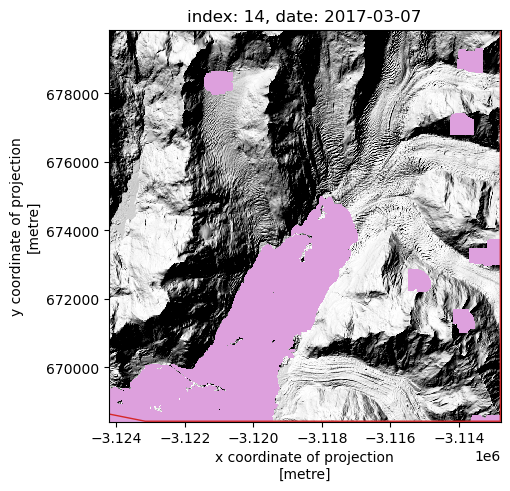

In [24]:
# Look at one of the strip preview figures
f = preview_strip(strips, bounds, 14)

It would be annoying to look at more than a few figures within this notebook itself. Instead, the next cell creates a figure for each strip returned by the search and saves that figure as a `.png` file to the `strip_preview` subdirectory of the data directory.

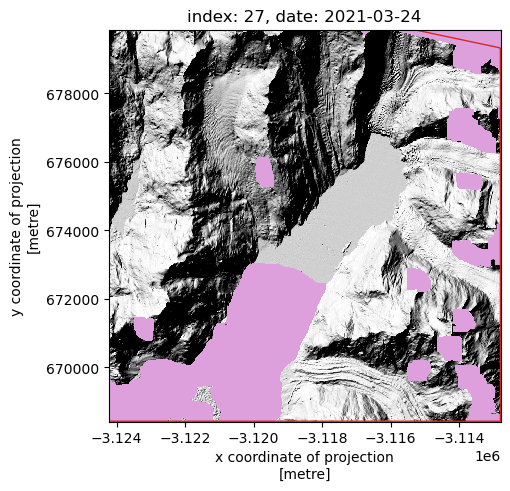

In [25]:
STRIP_PREVIEWS_DIR = DATA_DIR / "strip_previews"

# Make sure the output directory exists
if not STRIP_PREVIEWS_DIR.exists():
    STRIP_PREVIEWS_DIR.mkdir(parents=True)

# Create and save a figure for each row in strips
# The figures are named by the acquire date
for index in range(strips.shape[0]):
    # Extract the acquire date as a YYYY-MM-DD string
    title = strips.iloc[[index]].acqdate1.dt.date.values[0]

    # Define the output file path
    filepath = STRIP_PREVIEWS_DIR / f"{title}.png"

    # Create and save the figure
    f = preview_strip(strips, bounds, index)
    f.savefig(filepath, format="png")

After inspecting the strip previews, we will select the strips for dates `2012-08-13` and `2018-04-16` for use in our change detection analysis.

In [26]:
# Build a list of single row GeoDataFrames for two selected images
selected_rows = [
    strips.iloc[[1]],
    strips.iloc[[21]],
]

## TODO: Continue adding markdown cells and code comments below

In [16]:
STRIP_DIR = Path(__name__).resolve().parent / "data/strips"

if not STRIP_DIR.exists():
    STRIP_DIR.mkdir(parents=True)


def download_strip(row: gpd.GeoDataFrame, bounds: Polygon, output_dir: Path):
    filename = f"{row.acqdate1.dt.date.values[0]}.tif"
    filepath = output_dir / filename
    dem = pdt.load.from_search(row, bounds, bitmask=True)
    dem.compute()
    dem.rio.to_raster(filepath)

In [17]:
# for row in selected_rows:
#     download_strip(row, bounds, STRIP_DIR)

## Backgound Data

In [18]:
from dataclasses import dataclass

import pystac


@dataclass(frozen=True)
class PCCollectionInfo:
    """Data container for storing relevant metadata for using assets in MicroSoft's Planetary Computer STAC Catalogs"""

    collection: str
    asset_stac_key: str
    docs_url: str

    def get_asset_url(self, item: pystac.Item) -> str:
        return item.assets[self.asset_stac_key].href

In [19]:
import geopandas as gpd
import pystac_client
from pystac_client.item_search import ItemCollection


def search_planetary_computer_stac(
    collection: str,
    features: gpd.GeoDataFrame,
) -> ItemCollection:
    STAC_URL = "https://planetarycomputer.microsoft.com/api/stac/v1"

    dissolved_geom: gpd.GeoDataFrame = features.dissolve().iloc[0].geometry

    catalog = pystac_client.Client.open(STAC_URL)
    search = catalog.search(collections=[collection], intersects=dissolved_geom)
    return search.item_collection()

In [20]:
import pystac


def get_asset_href(item: pystac.Item, asset_stac_key: str) -> str:
    return item.assets[asset_stac_key].href

In [21]:
from pathlib import Path
import rioxarray


def download_raster(url: str, dst: Path) -> Path:
    # Make sure the dst directory exists
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)

    # Open the remote raster as a DataArray using the chunking to prevent loading
    # of the entire raster at once
    xds = rioxarray.open_rasterio(url, chunks=True)

    # Write the raster to the filesystem
    xds.rio.to_raster(dst)

    # Return the path to the downloaded raster
    return dst

In [22]:
from pathlib import Path
import geopandas as gpd
import rioxarray
import pdemtools as pdt


def clip_raster(src: Path, dst: Path, aoi: gpd.GeoDataFrame) -> Path:
    # Determine the clipping bounds in the src crs from the provided aoi
    xds = rioxarray.open_rasterio(src)
    src_crs = xds.rio.crs
    bounds = aoi.to_crs(src_crs).iloc[0].geometry

    # Load a clipped version of the raster
    xds = pdt.load.from_fpath(dem_fpath=src, bounds=bounds)

    # Write the clipped raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the clipped raster
    return dst

In [23]:
from pathlib import Path
import rioxarray
from rasterio.enums import Resampling


def reproject_raster(
    src: Path,
    dst: Path,
    dst_epsg: int,
    dst_nodata: float | int,
    resampling_method: Resampling,
) -> Path:
    # Load the src raster as a DataArray
    xds = rioxarray.open_rasterio(src)

    # Reproject to the dst crs, filling around the edges with the specified nodata value
    xds = xds.rio.reproject(
        dst_crs=f"EPSG:{dst_epsg}", resampling=resampling_method, nodata=dst_nodata
    )

    # Write the reprojected raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the reprojected raster
    return dst

In [24]:
cop30_info = PCCollectionInfo(
    collection="cop-dem-glo-30",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/cop-dem-glo-30",
)

In [25]:
cop30_items = search_planetary_computer_stac(
    collection=cop30_info.collection,
    features=aoi,
)
cop30_items

In [26]:
DATA_DIR = Path(__name__).parent / "data"

# Extract collection constants to local variable for readability
collection = cop30_info.collection
url = cop30_info.get_asset_url(item=cop30_items[0])

# Define the destination path for each raster stage
downloaded_dst = DATA_DIR / "background" / f"{collection}.tif"
clipped_dst = DATA_DIR / "background" / f"{collection}-clipped.tif"
reprojected_dst = DATA_DIR / "background" / f"{collection}-proj.tif"


# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=3413,
        dst_nodata=-9999.0,
        resampling_method=Resampling.bilinear,
    )

# Store the path to the reprojected raster to a named variable that won't be overwritten
cop30_raster = reprojected_dst

In [27]:
cop30_xds = rioxarray.open_rasterio(filename=cop30_raster)

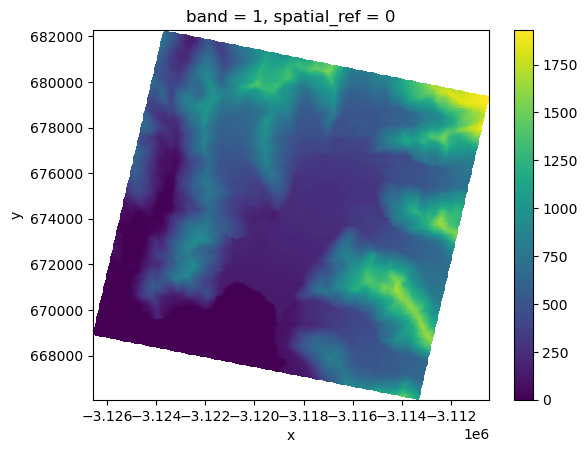

In [28]:
cop30_xds.where(cop30_xds != cop30_xds.rio.nodata).plot()

In [29]:
land_info = PCCollectionInfo(
    collection="io-lulc-annual-v02",
    asset_stac_key="data",
    docs_url="https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02",
)

In [30]:
land_items = search_planetary_computer_stac(
    collection=land_info.collection,
    features=aoi,
)
land_items

In [31]:
DATA_DIR = Path(__name__).parent / "data"

# Extract collection constants to local variable for readability
collection = land_info.collection
url = land_info.get_asset_url(item=land_items[0])

# Define the destination path for each raster stage
downloaded_dst = DATA_DIR / "background" / f"{collection}.tif"
clipped_dst = DATA_DIR / "background" / f"{collection}-clipped.tif"
reprojected_dst = DATA_DIR / "background" / f"{collection}-proj.tif"


# Download the source raster
if not downloaded_dst.exists():
    # Only run if the destination raster doesn't already exist
    download_raster(url=url, dst=downloaded_dst)

# Clip the downloaded raster to the project AOI
if not clipped_dst.exists():
    # Only run if the destination raster doesn't already exist
    clip_raster(src=downloaded_dst, dst=clipped_dst, aoi=aoi)

# Reproject the clipped raster to the same projection as the strips
if not reprojected_dst.exists():
    # Only run if the destination raster doesn't already exist
    reproject_raster(
        src=clipped_dst,
        dst=reprojected_dst,
        dst_epsg=3413,
        dst_nodata=0,
        resampling_method=Resampling.bilinear,
    )

# Store the path to the reprojected raster to a named variable that won't be overwritten
land_raster = reprojected_dst

In [32]:
land_xds = rioxarray.open_rasterio(filename=land_raster)

In [33]:
land_xds

<xarray.DataArray (band: 1, y: 1557, x: 1557)>
[2424249 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -3.127e+06 -3.127e+06 ... -3.11e+06 -3.11e+06
  * y            (y) float64 6.822e+05 6.822e+05 ... 6.661e+05 6.661e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [34]:
import rasterio
import numpy as np
from matplotlib.colors import ListedColormap


def get_land_colormap(asset_url: str) -> ListedColormap:
    # The code below is adapted from the example notebook for the same data source
    # https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02#Example-Notebook
    class_names = {
        "No Data": 0,
        "Water": 1,
        "Trees": 2,
        "Flooded vegetation": 4,
        "Crops": 5,
        "Built area": 7,
        "Bare ground": 8,
        "Snow/ice": 9,
        "Clouds": 10,
        "Rangeland": 11,
    }

    with rasterio.open(asset_url) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 255
            for i in range(max(class_names.values()) + 1)
        ]  # transform to matplotlib color format

    return ListedColormap(colormap)

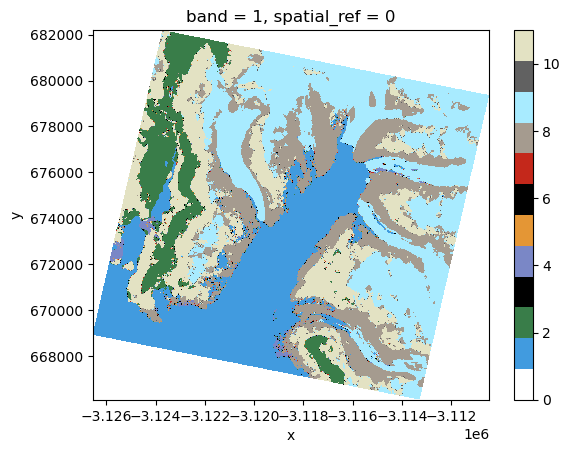

In [35]:
# TODO: Add cmap labels
land_cmap = get_land_colormap(url)
land_xds.plot(cmap=land_cmap)

## Coregister Strip DEMs

In [36]:
from pathlib import Path

DATA_DIR = Path(__name__).parent / "data"

DEM_2012_PATH = DATA_DIR / "strips/2012-08-13.tif"
DEM_2018_PATH = DATA_DIR / "strips/2018-04-16.tif"
DEM_REF_PATH = DATA_DIR / "background/cop-dem-glo-30-proj.tif"
LAND_REF_PATH = DATA_DIR / "background/io-lulc-annual-v02-proj.tif"

In [37]:
from pathlib import Path
import rioxarray


def extract_unstable_ground_raster(src: Path, dst: Path, exclude_value: int) -> Path:
    # Load the raster to extract values from
    xds = rioxarray.open_rasterio(filename=src)

    # Filter the excluded cell value
    xds = xds.where(xds != exclude_value)

    # Write the extracted raster to the filesystem, making sure the destination
    # directory exists beforehand.
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True)
    xds.rio.to_raster(dst)

    # Return the path to the extracted raster
    return dst

In [38]:
unstable_ground_path = DATA_DIR / "background/io-lulc-annual-v02-proj-unstable.tif"

extract_unstable_ground_raster(
    src=LAND_REF_PATH, dst=unstable_ground_path, exclude_value=8
)

PosixPath('data/background/io-lulc-annual-v02-proj-unstable.tif')

In [39]:
import geoutils
import xdem

dem_2012 = xdem.DEM(filename_or_dataset=DEM_2012_PATH)
dem_2018 = xdem.DEM(filename_or_dataset=DEM_2018_PATH)
dem_ref = xdem.DEM(filename_or_dataset=DEM_REF_PATH).reproject(dst_ref=dem_2012)
unstable_ground_mask = geoutils.Mask(unstable_ground_path).reproject(
    dst_ref=dem_2012, src_nodata=0
)

In [40]:
import xdem
import matplotlib.pyplot as plt


def plot_pre_coregistration():
    plt.close("all")
    fig, axes = plt.subplots(
        figsize=(10, 6.5), ncols=2, nrows=2, sharex=True, sharey=True
    )

    ax = axes[0, 0]
    ax.set_title("Reference DEM")
    xdem.terrain.hillshade(dem=dem_ref).show(ax=ax, cmap="Greys_r")

    ax = axes[0, 1]
    ax.set_title("Unstable Ground Mask")
    unstable_ground_mask.show(ax=ax)

    ax = axes[1, 0]
    ax.set_title("2012 DEM")
    xdem.terrain.hillshade(dem=dem_2012).show(ax=ax, cmap="Greys_r")

    ax = axes[1, 1]
    ax.set_title("2018 DEM")
    xdem.terrain.hillshade(dem=dem_2018).show(ax=ax, cmap="Greys_r")

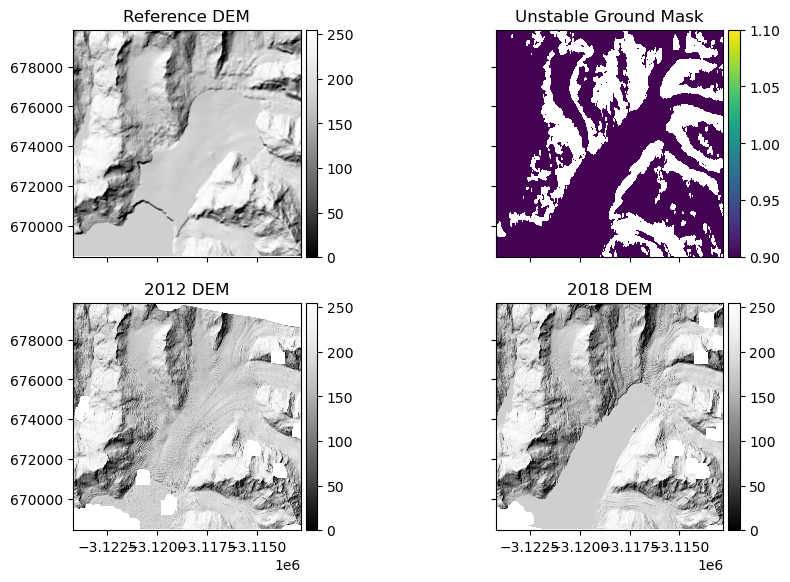

In [41]:
plot_pre_coregistration()

In [42]:
import geoutils
import xdem


def coregister_dem(
    reference_dem: xdem.DEM, dem_to_be_aligned: xdem.DEM, inlier_mask: geoutils.Mask
) -> xdem.DEM:
    coreg_pipeline = xdem.coreg.NuthKaab()

    coreg_pipeline = coreg_pipeline.fit(reference_dem, dem_to_be_aligned, inlier_mask)

    return coreg_pipeline.apply(dem=dem_to_be_aligned)

In [43]:
dem_2012_coreg = coregister_dem(
    reference_dem=dem_ref, dem_to_be_aligned=dem_2012, inlier_mask=unstable_ground_mask
)

In [53]:
DEM_2012_COREG_PATH = DATA_DIR / "strips/2012-08-13-coreg.tif"
dem_2012_coreg.save(DEM_2012_COREG_PATH)

In [54]:
dem_2012_coreg = xdem.DEM(DEM_2012_COREG_PATH)

In [44]:
dem_2018_coreg = coregister_dem(
    reference_dem=dem_ref, dem_to_be_aligned=dem_2018, inlier_mask=unstable_ground_mask
)

In [55]:
DEM_2018_COREG_PATH = DATA_DIR / "strips/2018-04-16-coreg.tif"
dem_2018_coreg.save(DEM_2018_COREG_PATH)

In [56]:
dem_2018_coreg = xdem.DEM(DEM_2018_COREG_PATH)

In [45]:
import xdem
import matplotlib.pyplot as plt


def plot_post_coregistration():
    plt.close("all")
    fig, axes = plt.subplots(
        figsize=(10, 6.5), ncols=2, nrows=2, sharex=True, sharey=True
    )

    ax = axes[0, 0]
    ax.set_title("Coregistered 2012 DEM")
    xdem.terrain.hillshade(dem=dem_2012).show(ax=ax, cmap="Greys_r")

    ax = axes[0, 1]
    ax.set_title("Coregistered 2018 DEM")
    xdem.terrain.hillshade(dem=dem_2018).show(ax=ax, cmap="Greys_r")

    ax = axes[1, 0]
    ax.set_title("2012 Coregistration Change")
    (dem_2012_coreg - dem_2012).show(
        ax=ax, vmin=-50, vmax=0, cmap="Reds_r", cbar_title="Elevation change (m)"
    )

    ax = axes[1, 1]
    ax.set_title("2018 Coregistration Change")
    (dem_2018_coreg - dem_2018).show(
        ax=ax, vmin=-50, vmax=0, cmap="Reds_r", cbar_title="Elevation change (m)"
    )
    plt.show()

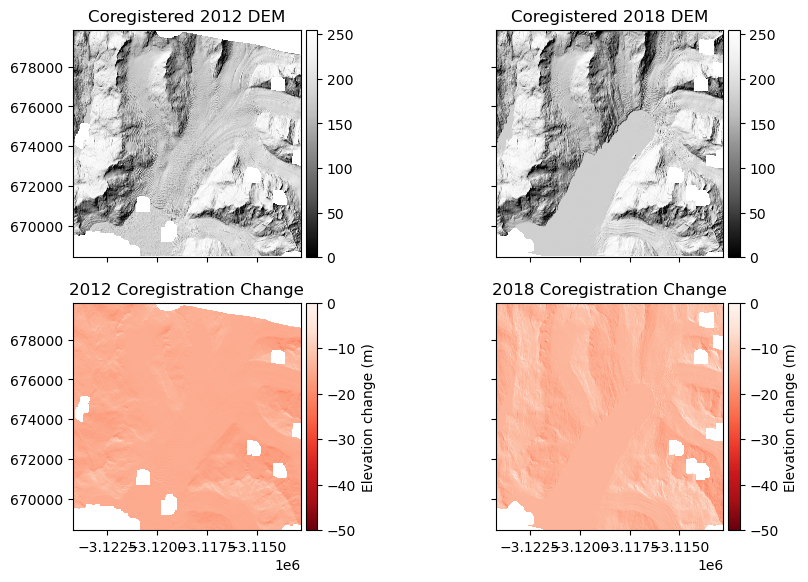

In [46]:
plot_post_coregistration()

## Visualizing Change with Differencing

In [47]:
diff = dem_2018_coreg - dem_2012_coreg

In [48]:
print(diff.info(stats=True))

Driver:               None 
Opened from file:     None 
Filename:             None 
Loaded?               True 
Modified since load?  True 
Size:                 5717, 5716
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    ['EPSG:3413']
NoData Value:         -9999.0
Pixel Size:           2.0, 2.0
Upper Left Corner:    -3124226.0, 668428.0
Lower Right Corner:   -3112792.0, 679860.0
[MAXIMUM]:          129.93
[MINIMUM]:          -296.45
[MEDIAN]:           -0.82
[MEAN]:             -38.28
[STD DEV]:          67.70



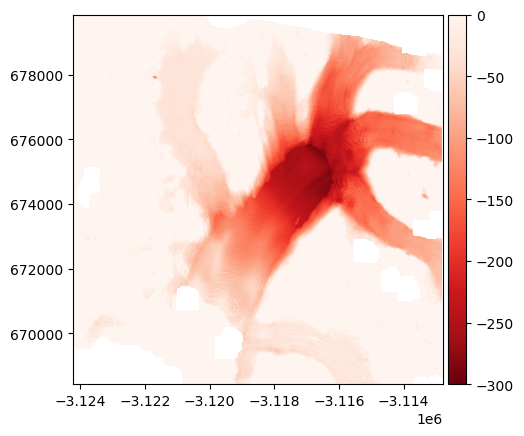

In [49]:
vrange = 300
vmin = 0 - vrange
vmax = 0

diff.show(cmap="Reds_r", vmin=vmin, vmax=vmax)

In [50]:
def plot_terrain_attribues(dem: xdem.DEM):
    plt.close("all")
    attributes = xdem.terrain.get_terrain_attribute(
        dem.data,
        resolution=dem.res,
        attribute=[
            "hillshade",
            "slope",
            "aspect",
            "curvature",
            "terrain_ruggedness_index",
            "rugosity",
        ],
    )

    plt.figure(figsize=(11, 8.5))

    plt_extent = [dem.bounds.left, dem.bounds.right, dem.bounds.bottom, dem.bounds.top]

    cmaps = ["Greys_r", "Reds", "twilight", "RdGy_r", "Purples", "YlOrRd"]
    labels = [
        "Hillshade",
        "Slope (°)",
        "Aspect (°)",
        "Curvature (100 / m)",
        "Terrain Ruggedness Index",
        "Rugosity",
    ]
    vlims = [(None, None) for i in range(6)]
    vlims[3] = [-2, 2]

    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.imshow(
            attributes[i].squeeze(),
            cmap=cmaps[i],
            extent=plt_extent,
            vmin=vlims[i][0],
            vmax=vlims[i][1],
        )
        cbar = plt.colorbar()
        cbar.set_label(labels[i])
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()

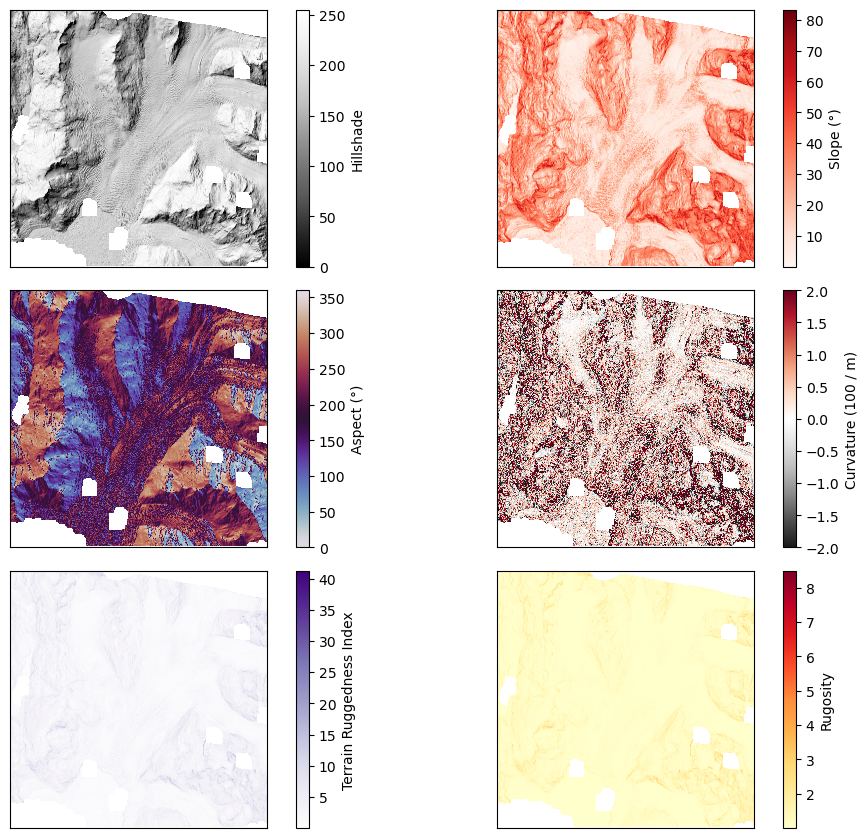

In [51]:
plot_terrain_attribues(dem=dem_2012_coreg)

In [68]:
from pathlib import Path
import leafmap


def create_interactive_dem_map(dems: list[Path]) -> leafmap.Map:
    m = initialize_default_interactive_map()

    # Add data to the map. Each call to m.add_<something> places that data on the top of
    # the visual hierarchy. Therefore we will generally want to add basemaps first, rasters
    # second, and vectors last.

    # Add relevant basemaps
    m.add_basemap("Esri.WorldImagery", show=True)
    m.add_basemap("USGS.USImagery", show=False)

    # Add DEMs
    for dem in dems:
        m.add_raster(source=str(dem), layer_name=dem.stem)

    # No vector data

    return m

In [69]:
interactive_map = create_interactive_dem_map(
    dems=[DEM_2012_COREG_PATH, DEM_2018_COREG_PATH, DEM_REF_PATH]
)
interactive_map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Things to try next

- Look at more than two DEMs
- Extract glacier terminus from rasters